In [248]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns
from scipy import stats
import math

import statsmodels.api as sm
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Lasso, Ridge

from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, normalize
from sklearn.metrics import r2_score, mean_absolute_error

### Error Functions

In [381]:
def mae_value(X_test,y_test, model, ):
    '''
    return MAE of a model based on test data
    '''
    #test_set_pred = lasso_model.predict(X_test.loc[:,selected_columns])
    yhat = model.predict(X_test)

    #mae
    return mean_absolute_error(y_test, yhat)

def adjusted_r2_value( X_test,y_test,model):
    '''
    return r2 of a model based on test data
    '''
    #test_set_pred = lasso_model.predict(X_test.loc[:,selected_columns])
    yhat = model.predict(X_test)
    
    adjusted_r2 = 1 - (1-r2_score(y_test, yhat))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
    #adjusted_r2 = 1 - (1-model.score(X_test,y_test))*((len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
    
    return adjusted_r2

def r2_value( X_test,y_test,model):
    '''
    return r2 of a model based on test data
    '''
    #test_set_pred = lasso_model.predict(X_test.loc[:,selected_columns])
    yhat = model.predict(X_test)
    
    return r2_score(y_test, yhat)

### Plotting and Coefficients

In [250]:
def plot_pred_vs_actual(X_test,y_test, model):
    '''
    plot y prediction against y test
    '''
    #test_set_pred = lasso_model.predict(X_test.loc[:,selected_columns])
    yhat = model.predict(X_test)
    
    #format plot
    plt.rcParams.update({'font.size': 12})    
    plt.title("Predicted VS Actual")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.figure(figsize=(10,5))
    
    #plot 
    plt.scatter(yhat, y_test, alpha=.2, color = '#3468bc')
    plt.plot(np.linspace(0,100000,1000), np.linspace(0,150000,1000))
    x_plot = np.linspace(0, 1, 100)
    
def diagnostic_plot(X, y):
    plt.figure(figsize=(20,5))
    
    rgr = LinearRegression()
    rgr.fit(X,y)
    pred = rgr.predict(X)

    plt.subplot(1, 3, 1)
    plt.scatter(X,y)
    plt.plot(X, pred, color='blue',linewidth=1)
    plt.title("Regression fit")
    plt.xlabel("x")
    plt.ylabel("y")
    
    plt.subplot(1, 3, 2)
    res = y - pred
    plt.scatter(pred, res)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")
    
def get_feature_coefs(model,linear,X_train):
    #linear coefs
    if linear:
        print('Feature coefficient results: \n')
        for feature, coef in zip(X_train.columns, model.coef_):
            print(f'Coef of {feature} is : {coef:.2f}')

        return zip(X_train.columns, model.coef_)
    #poly coef
    else:
        print('Feature coefficient results: \n')
        for feature, coef in zip(model.get_feature_names(), model.coef_):
            print( f'Coef of {feature} is : {coef:.2f}')

        return zip(model.get_feature_names(), model.coef_)   

### Regression Functions with Cross Validation

In [251]:
def linear_regression_with_cv(X_train, y_train):
    '''
    print r2 val score and feature coefficient results
    return model
    '''
    #this helps with the way kf will generate indices below
    X, y = np.array(X_train), np.array(y_train)
    kf = KFold(n_splits=5, shuffle=True, random_state = 71) #randomly shuffle before splitting
    r2_train = []
    r2_adj = [] #collect the adj val r2 results
    r2_val = [] #collect the val r2 results
    mae = [] #collect mae results
    
    #returns 5 index sets for cross vallidation
    for train_ind, val_ind in kf.split(X,y):
    
        X_train, y_train = X[train_ind], y[train_ind]
        X_val, y_val = X[val_ind], y[val_ind] 
        
        #simple linear regression
        lm = LinearRegression()
        lm.fit(X_train, y_train)
        r2_train.append(round(r2_value(X_train, y_train, lm), 3))
        r2_adj.append(round(adjusted_r2_value(X_val, y_val, lm), 3))
        r2_val.append(round(r2_value(X_val, y_val, lm), 3))
        mae.append(round(mae_value(X_val, y_val, lm),3))
        
    #report results
    print(f'Simple mean cv r^2 train score: {np.mean(r2_train):.3f} +- {np.std(r2_train):.3f}')
    print(f'Simple mean cv r^2 val score: {np.mean(r2_val):.3f} +- {np.std(r2_val):.3f}')
    print(f'Simple mean cv adjusted r^2 val score: {np.mean(r2_adj):.3f} +- {np.std(r2_adj):.3f}')
    print(f'Simple mean cv mae: {np.mean(mae):.3f} +- {np.std(mae):.3f}')
    
    return lm

def polynomial_regression_with_cv(X_train, y_train, degree, interaction):
    '''
    print r2 val score and polynomial feature coefficient results
    return model
    '''
    #this helps with the way kf will generate indices below
    X, y = np.array(X_train), np.array(y_train)
    kf = KFold(n_splits=5, shuffle=True, random_state = 71) #randomly shuffle before splitting
    r2_train = []
    r2_adj = [] #collect the adj val results
    r2_val = [] #collect the validation results
    mae = [] #collect mae results
    
    #returns 5 index sets for cross vallidation
    for train_ind, val_ind in kf.split(X,y):
    
        X_train, y_train = X[train_ind], y[train_ind]
        X_val, y_val = X[val_ind], y[val_ind] 
        
        #create polynomial features
        poly = PolynomialFeatures(degree=degree, interaction_only = interaction)
        X_train_poly = poly.fit_transform(X_train)
        X_val_poly = poly.transform(X_val)
        
        #fit poly features to linear regression to training data
        lm_poly = LinearRegression()
        lm_poly.fit(X_train_poly, y_train)
        r2_adj.append(round(adjusted_r2_value(X_val_poly, y_val, lm_poly), 3))
        r2_val.append(round(r2_value( X_val_poly,y_val, lm_poly), 3))
        r2_train.append(round(r2_value( X_train_poly,y_train, lm_poly), 3))
        mae.append(round(mae_value(X_val_poly,y_val, lm_poly),3))
    
    #report results
    print(f'Results for {degree} degree, interaction_only = {interaction} polynomial regression:')
    print(f'Simple mean cv r^2 train score: {np.mean(r2_train):.3f} +- {np.std(r2_train):.3f}')
    print(f'Simple mean cv r^2 val score: {np.mean(r2_val):.3f} +- {np.std(r2_val):.3f}')
    print(f'Simple mean cv adjusted r^2 val score: {np.mean(r2_adj):.3f} +- {np.std(r2_adj):.3f}')
    print(f'Simple mean cv mae: {np.mean(mae):.3f} +- {np.std(mae):.3f}')
    
    return lm_poly

### Manual Lasso and Ridge

In [252]:
def manual_ridge_cv(X_train, y_train, alpha):   
    #this helps with the way kf will generate indices below
    X, y = np.array(X_train), np.array(y_train)
    kf = KFold(n_splits=5, shuffle=True, random_state=23) #randomly shuffle before splitting
    r2_train, r2_val, r2_adj, mae = [], [], [], []

    for train_ind, val_ind in kf.split(X, y):
        X_train, y_train = X[train_ind], y[train_ind]
        X_val, y_val = X[val_ind], y[val_ind]

        l_ridge = Ridge(alpha=alpha)
        l_ridge.fit(X_train, y_train)

        r2_train.append(round(r2_value( X_train, y_train, l_ridge), 3))
        r2_val.append(round(r2_value( X_val, y_val, l_ridge), 3))
        r2_adj.append(round(adjusted_r2_value(X_val, y_val, l_ridge),3))
        mae.append(round(mae_value(X_val, y_val, l_ridge),3))

    print(f'Ridge regression results for aplpha = {alpha}:\n'
          f'R^2 Train: {np.mean(r2_train)},\n'
          f'R^2 Val: {np.mean(r2_val)},\n'
          f'Adjusted R^2 Val: {np.mean(r2_adj)},\n'
          f'MAE: {np.mean(mae)},')
    
    return l_ridge
    
def manual_lasso_cv(X_train, y_train, alpha):   
    #this helps with the way kf will generate indices below
    X, y = np.array(X_train), np.array(y_train)
    kf = KFold(n_splits=5, shuffle=True, random_state=23) #randomly shuffle before splitting
    r2_train, r2_val, r2_adj, mae = [], [], [], []

    for train_ind, val_ind in kf.split(X, y):
        X_train, y_train = X[train_ind], y[train_ind]
        X_val, y_val = X[val_ind], y[val_ind]

        l_lasso = Lasso(alpha=alpha)
        l_lasso.fit(X_train, y_train)

        r2_train.append(round(r2_value( X_train, y_train, l_lasso), 3))
        r2_val.append(round(r2_value( X_val, y_val, l_lasso), 3))
        r2_adj.append(round(adjusted_r2_value(X_val, y_val, l_lasso),3))
        mae.append(round(mae_value(X_val, y_val, l_lasso),3))

    print(f'Lasso regression results for aplpha = {alpha}:\n'
          f'R^2 Train: {np.mean(r2_train)},\n'
          f'R^2 Val: {np.mean(r2_val)},\n'
          f'Adjusted R^2 Val: {np.mean(r2_adj)},\n'
          f'MAE: {np.mean(mae)},')
    
    return l_lasso

### Manual Scaled Lasso and Ridge

In [253]:
def manual_scaled_ridge_cv(X_train, y_train, alpha):   
    #this helps with the way kf will generate indices below
    X, y = np.array(X_train), np.array(y_train)
    kf = KFold(n_splits=5, shuffle=True, random_state=23) #randomly shuffle before splitting
    r2_train, r2_val, r2_adj, mae = [], [], [], []

    for train_ind, val_ind in kf.split(X, y):
        X_train, y_train = X[train_ind], y[train_ind]
        X_val, y_val = X[val_ind], y[val_ind]
        
        scaler = StandardScaler(with_mean=False)
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)

        l_ridge = Ridge(alpha=alpha)
        l_ridge.fit(X_train_scaled, y_train)

        r2_train.append(round(r2_value( X_train_scaled, y_train, l_ridge), 3))
        r2_val.append(round(r2_value( X_val_scaled, y_val, l_ridge), 3))
        r2_adj.append(round(adjusted_r2_value(X_val_scaled, y_val, l_ridge),3))
        mae.append(round(mae_value(X_val_scaled, y_val, l_ridge),3))

    print(f'Ridge regression results for aplpha = {alpha}:\n'
          f'R^2 Train: {np.mean(r2_train)},\n'
          f'R^2 Val: {np.mean(r2_val)},\n'
          f'Adjusted R^2 Val: {np.mean(r2_adj)},\n'
          f'MAE: {np.mean(mae)},')
    
    return l_ridge
    
def manual_scaled_lasso_cv(X_train, y_train, alpha):   
    #this helps with the way kf will generate indices below
    X, y = np.array(X_train), np.array(y_train)
    kf = KFold(n_splits=5, shuffle=True, random_state=23) #randomly shuffle before splitting
    r2_train, r2_val, r2_adj, mae = [], [], [], []

    for train_ind, val_ind in kf.split(X, y):
        X_train, y_train = X[train_ind], y[train_ind]
        X_val, y_val = X[val_ind], y[val_ind]
        
        scaler = StandardScaler(with_mean=False)
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)

        l_lasso = Lasso(alpha=alpha)
        l_lasso.fit(X_train_scaled, y_train)

        r2_train.append(round(r2_value( X_train_scaled, y_train, l_lasso), 3))
        r2_val.append(round(r2_value( X_val_scaled, y_val, l_lasso), 3))
        r2_adj.append(round(adjusted_r2_value(X_val_scaled, y_val, l_lasso),3))
        mae.append(round(mae_value(X_val_scaled, y_val, l_lasso),3))

    print(f'Lasso regression results for aplpha = {alpha}:\n'
          f'R^2 Train: {np.mean(r2_train)},\n'
          f'R^2 Val: {np.mean(r2_val)},\n'
          f'Adjusted R^2 Val: {np.mean(r2_adj)},\n'
          f'MAE: {np.mean(mae)},')
    
    return l_lasso

### LASSO and RidgeCV

In [254]:
def scaled_ridge_cv(folds, alpha_start, alpha_end, alpha_step, X_train, y_train, X_test, y_test):
    '''
    build ridge model, no features discarded and colinear features should have equal weight
    '''
    #scale data
    std = StandardScaler(with_mean=False)
    X_train_scaled = std.fit_transform(X_train)
    X_test_scaled = std.transform(X_test)
    
    cv = RepeatedKFold(n_splits=folds, n_repeats=5, random_state=10)
    # define model
    model = RidgeCV(alphas=np.arange(alpha_start, alpha_end, alpha_step), cv=cv, normalize=False)
    # fit model
    model.fit(X_train_scaled, y_train)
    
    print(f'Alpha: {model.alpha_}')
    print(f'MAE test value: {mae_value(X_test_scaled, y_test,  model)}')
    print(f'Adjusted r2 test score: {adjusted_r2_value( X_test_scaled,y_test, model)}') 
    print(f'R2 test score: {r2_value( X_test_scaled,y_test, model)}')
    print(f'R2 train score: {r2_value( X_train_scaled,y_train, model)}')
    
    return model

def scaled_lasso_cv(folds, alpha_start, alpha_end, alpha_step, X_train, y_train, X_test, y_test):  
    '''
    print optimized alpha of LassoCV val r2 train and r2 train mean 
    return model 
    '''
    #scale data
    std = StandardScaler(with_mean=False)
    X_train_scaled = std.fit_transform(X_train)
    X_test_scaled = std.transform(X_test)
    
    cv = RepeatedKFold(n_splits=folds, n_repeats=5, random_state=10)
    # define model
    model = LassoCV(alphas=np.arange(alpha_start, alpha_end, alpha_step), cv=cv, normalize=False)
    # fit model
    model.fit(X_train_scaled, y_train)
    
    print(f'Alpha: {model.alpha_}')
    print(f'MAE test value: {mae_value(X_test_scaled, y_test,  model)}')
    print(f'Adjusted r2 test score: {adjusted_r2_value( X_test_scaled,y_test, model)}') 
    print(f'R2 test score: {r2_value( X_test_scaled,y_test, model)}')
    print(f'R2 train score: {r2_value( X_train_scaled,y_train, model)}')
    
    return model

### Load Data

In [382]:
df = pd.read_csv('../Data/full_model_spec_sales_df_cleaned.csv')

# df1 = df.loc[:,['Model','Class', 'doors', 'passengers','price', 'speed_sec', 'horsepower_hp', 'drive', 'mpg', 'engine', 'tank_gal',
#                 'length_in', 'width_in','height_in', 'wheelbase_in', 'Total_Sales']]
drop_cols = ['Unnamed: 0',  'Year', 'cleaned_name']
df1 = df.drop(drop_cols, axis=1)
df1 = df1.dropna() #drop rows with null values
df1.info() #check for no null values

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1438 entries, 2 to 4084
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Total_Sales      1438 non-null   float64
 1   curb_weight_lbs  1438 non-null   float64
 2   speed_sec        1438 non-null   float64
 3   horsepower_hp    1438 non-null   float64
 4   width_in         1438 non-null   float64
 5   msrp             1438 non-null   float64
 6   pass_capacity    1438 non-null   float64
 7   doors            1438 non-null   float64
 8   wheelbase_in     1438 non-null   float64
 9   height_in        1438 non-null   float64
 10  tank_cap_gal     1438 non-null   float64
 11  length_in        1438 non-null   float64
 12  vol_cubft        1438 non-null   float64
 13  mpg_comb         1438 non-null   float64
 14  drivetrain       1438 non-null   object 
 15  fuel             1438 non-null   object 
 16  class            1438 non-null   object 
 17  transmission  

In [256]:
#find unique models
# df1['cleaned_name'].nunique()

## EDA

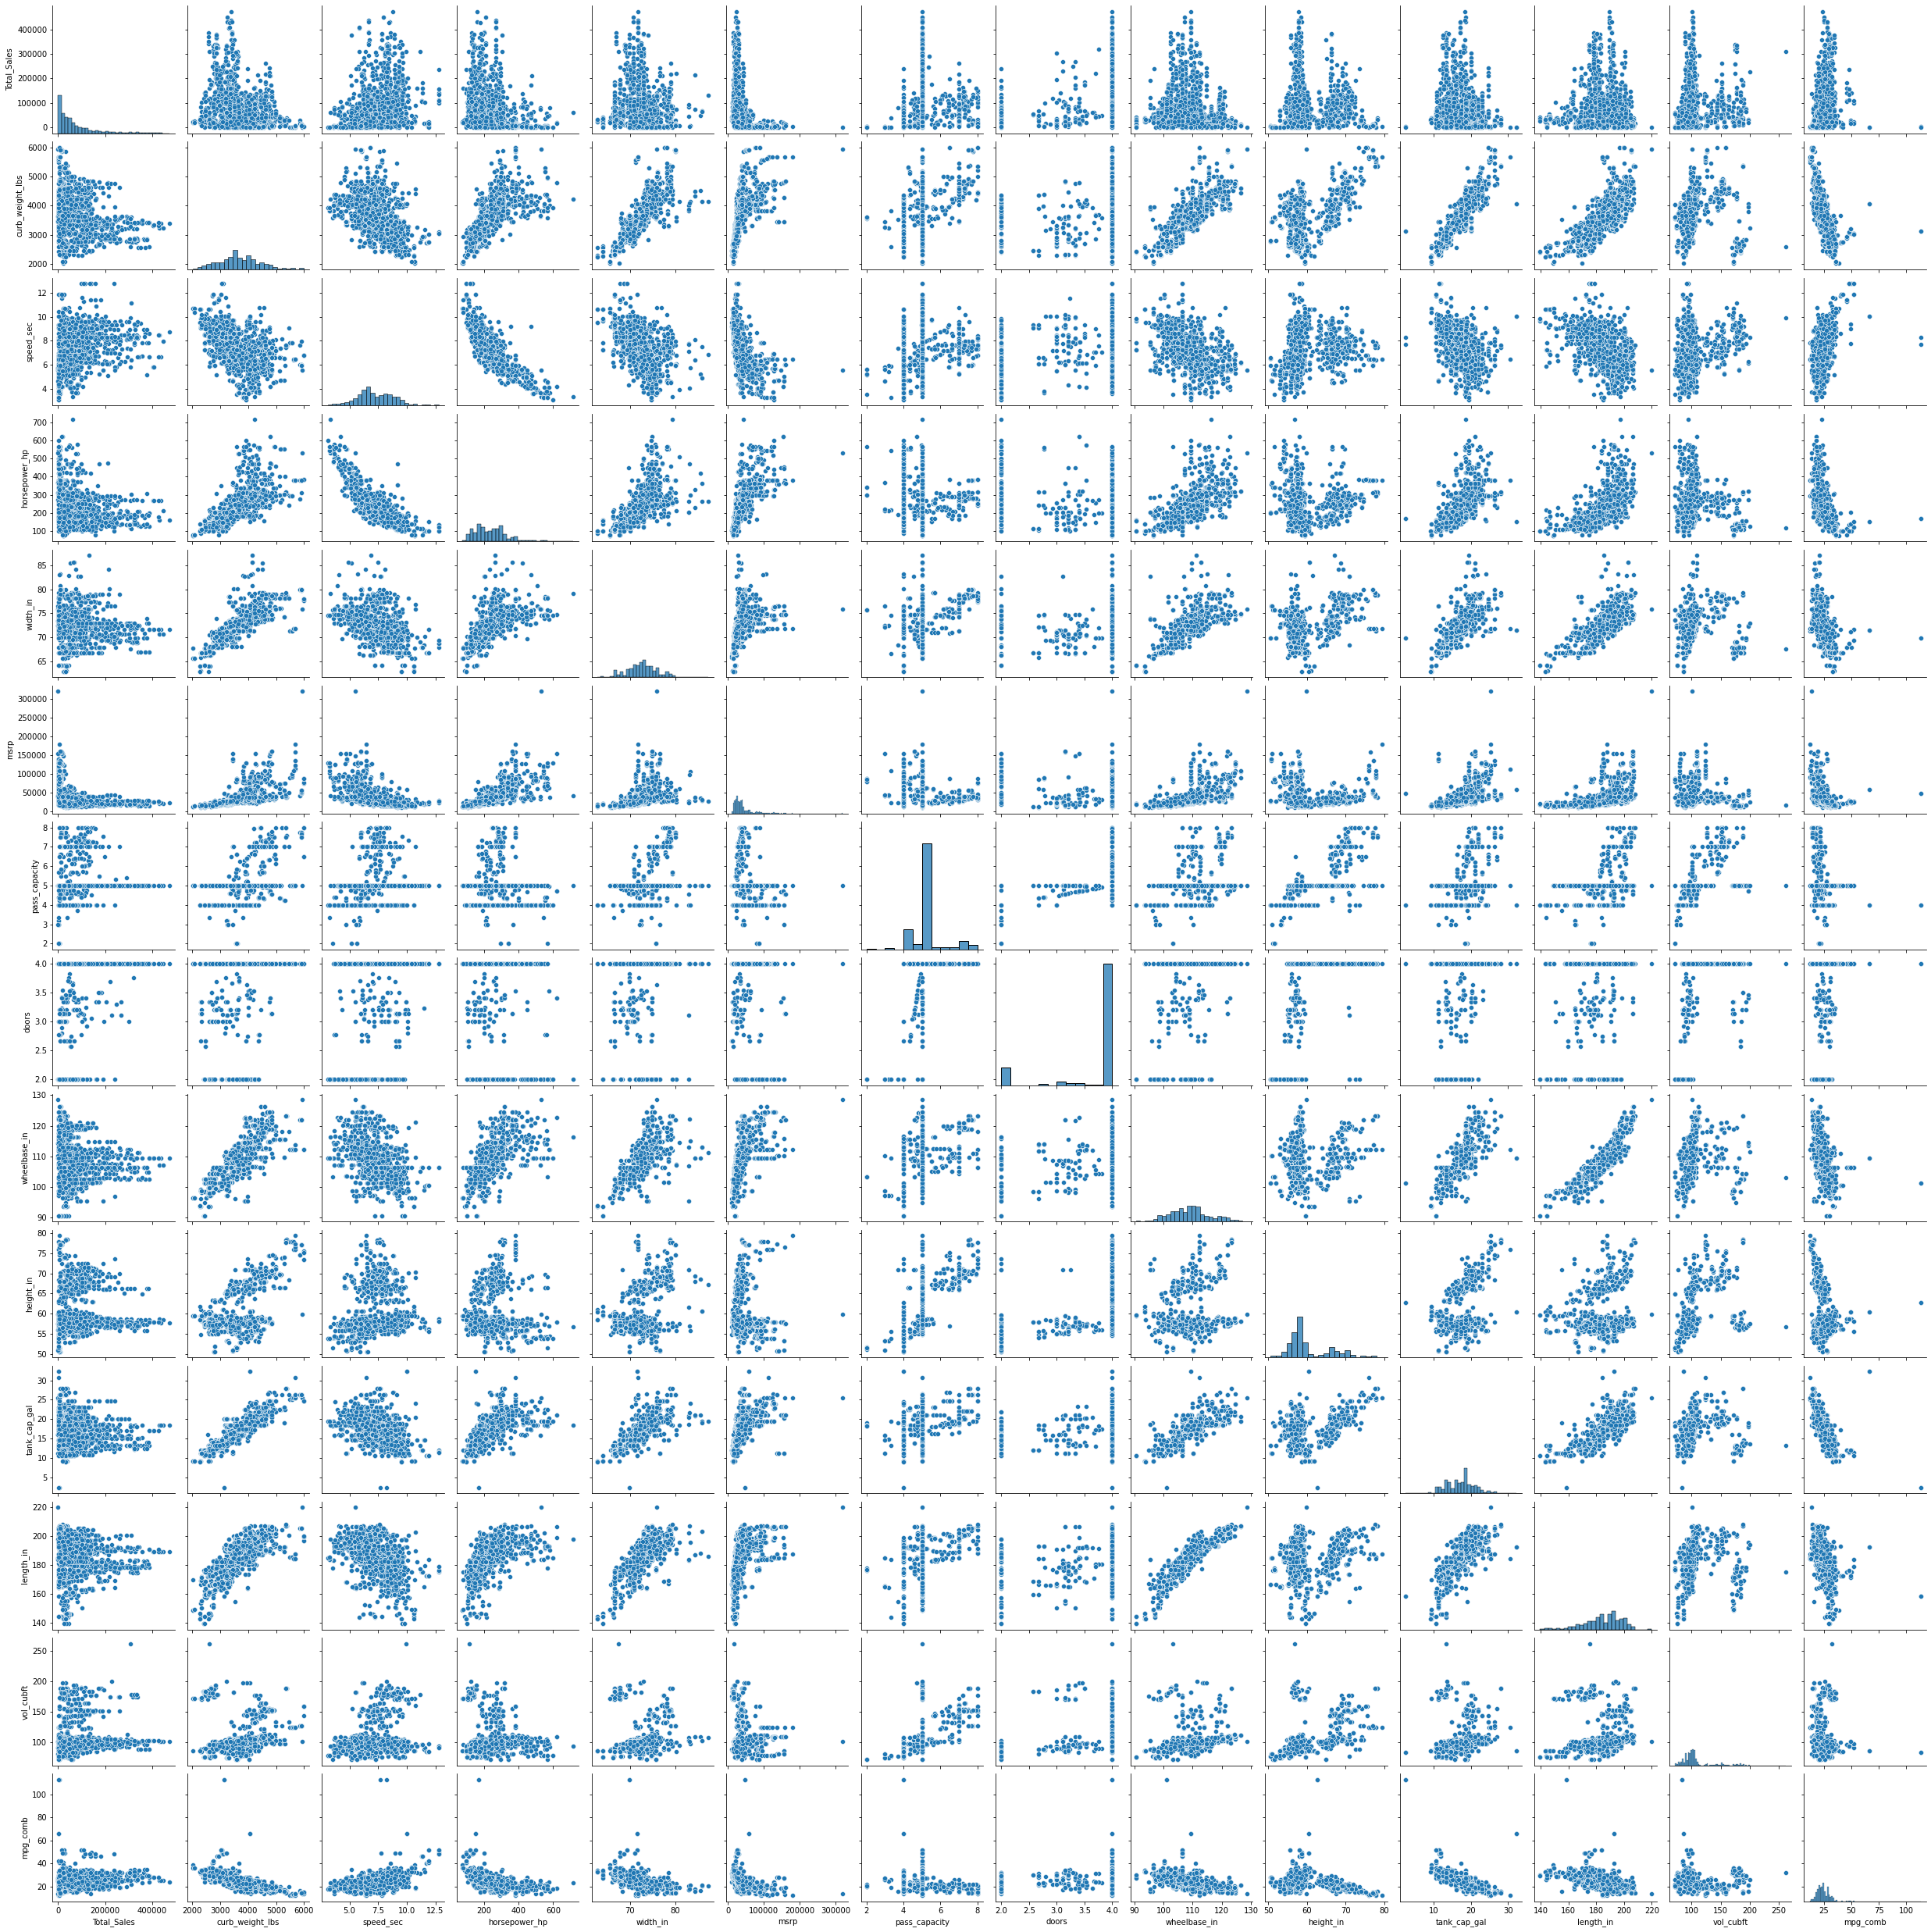

In [257]:
sns.pairplot(df1)

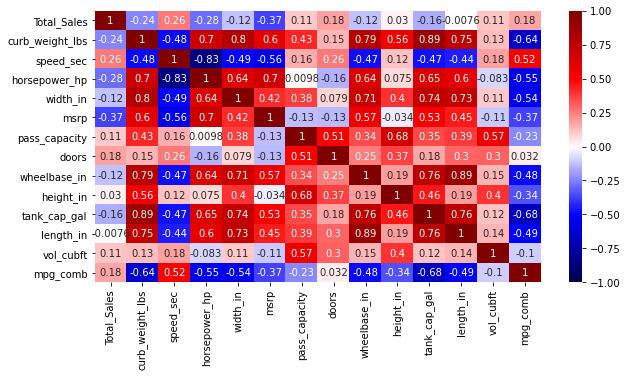

In [258]:
plt.figure(figsize=(10,5))
sns.heatmap(df1.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

Check categorical features to see if it is related to Total Sales

<AxesSubplot:xlabel='transmission', ylabel='Count'>

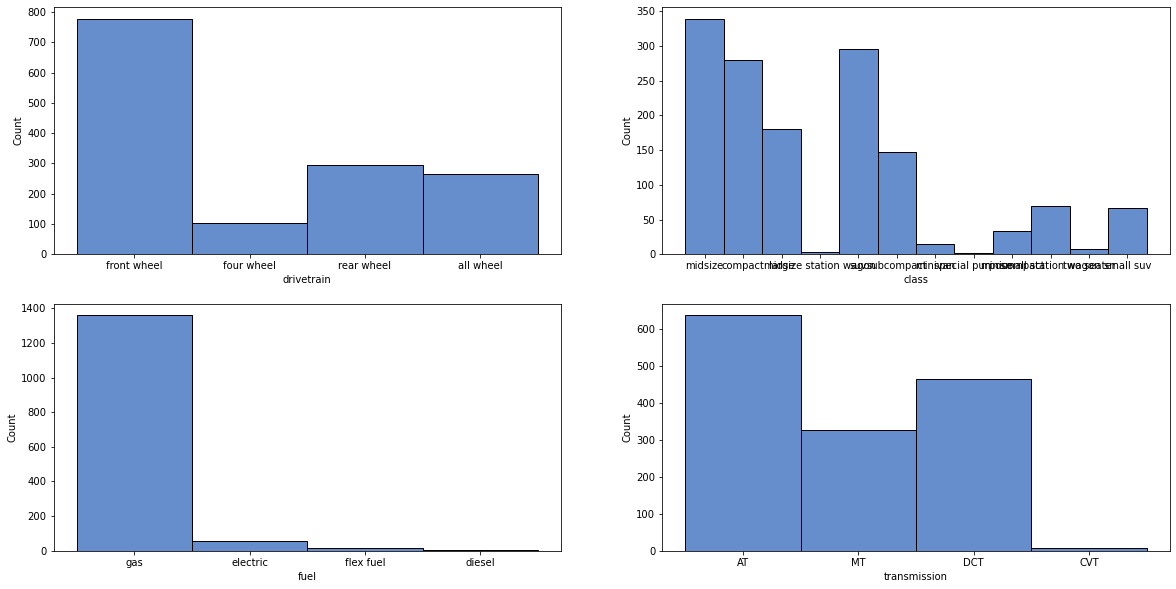

In [259]:
# Create 2x2 sub plots
gs = gridspec.GridSpec(2, 2, wspace=0.2)
plt.figure(figsize=(20,10))

ax = plt.subplot(gs[0, 0]) # row 0, col 0
sns.histplot(x=df1['drivetrain'], color = '#3468bc')

ax = plt.subplot(gs[0, 1]) # row 0, col 1
sns.histplot(x=df1['class'], color = '#3468bc')

ax = plt.subplot(gs[1, 0]) # row 0, col 3
sns.histplot(x=df1['fuel'], color = '#3468bc')

ax = plt.subplot(gs[1, 1]) # row 0, col 3
sns.histplot(x=df1['transmission'], color = '#3468bc')

#### Intial Takeaways

###### What is the distribution of the target?

heavily skewed to the left, not normal

##### Are there any colinearities in the feartures?

* Price

##### What are the relationships between each features and the targets

So far there does not appear to be any obvious linear relationships between features and the target

In [260]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1438 entries, 2 to 4084
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Total_Sales      1438 non-null   float64
 1   curb_weight_lbs  1438 non-null   float64
 2   speed_sec        1438 non-null   float64
 3   horsepower_hp    1438 non-null   float64
 4   width_in         1438 non-null   float64
 5   msrp             1438 non-null   float64
 6   pass_capacity    1438 non-null   float64
 7   doors            1438 non-null   float64
 8   wheelbase_in     1438 non-null   float64
 9   height_in        1438 non-null   float64
 10  tank_cap_gal     1438 non-null   float64
 11  length_in        1438 non-null   float64
 12  vol_cubft        1438 non-null   float64
 13  mpg_comb         1438 non-null   float64
 14  drivetrain       1438 non-null   object 
 15  fuel             1438 non-null   object 
 16  class            1438 non-null   object 
 17  transmission  

# Modeling

### Baseline Model

define features(X) and Target(y)

In [383]:
X = df1[[ 'doors', 'pass_capacity','msrp', 'speed_sec', 'horsepower_hp', 'drivetrain', 'mpg_comb', 'fuel', 'tank_cap_gal',
          'curb_weight_lbs', 'length_in', 'width_in','height_in', 'wheelbase_in', 'class', 'transmission', 'vol_cubft']]

y = df1['Total_Sales']

X = pd.get_dummies(X)

split data into train and test data 

In [384]:
# hold out 20% of the data for final testing
#change random state for new subset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=46)

In [385]:
#baseline linear model with cross validation
lm = linear_regression_with_cv(X_train,y_train)

Simple mean cv r^2 train score: 0.332 +- 0.009
Simple mean cv r^2 val score: 0.288 +- 0.040
Simple mean cv adjusted r^2 val score: 0.151 +- 0.048
Simple mean cv mae: 50280.918 +- 2850.240


In [386]:
#baseline polynomial model with interaction terms only
poly = polynomial_regression_with_cv(X_train,y_train, 2, True)

Results for 2 degree, interaction_only = True polynomial regression:
Simple mean cv r^2 train score: 0.748 +- 0.007
Simple mean cv r^2 val score: -300106829.823 +- 557935633.363
Simple mean cv adjusted r^2 val score: 144683083.649 +- 268983705.347
Simple mean cv mae: 82174839.182 +- 120581998.493


Severely negative R^2 score for polynomial regression tells us that the model is overfit and that evidence points towards a simple linear regression model.

In [387]:
#baseline lassocv
lasso = scaled_lasso_cv(5, 700, 1500, 5, X_train, y_train, X_test, y_test)
#get coeficients to see if any zeroed out
get_feature_coefs(model=lasso,linear=True,X_train=X_train)

Alpha: 700
MAE test value: 52877.95484815692
Adjusted r2 test score: 0.09900347433521561
R2 test score: 0.21515982084949092
R2 train score: 0.32135656297434667
Feature coefficient results: 

Coef of doors is : -0.00
Coef of pass_capacity is : -3501.90
Coef of msrp is : -12321.69
Coef of speed_sec is : 1587.01
Coef of horsepower_hp is : -2139.97
Coef of mpg_comb is : 5521.15
Coef of tank_cap_gal is : 0.00
Coef of curb_weight_lbs is : -31923.97
Coef of length_in is : 37421.79
Coef of width_in is : -0.00
Coef of height_in is : 0.00
Coef of wheelbase_in is : 980.36
Coef of vol_cubft is : -1979.68
Coef of drivetrain_all wheel is : -0.00
Coef of drivetrain_four wheel is : 12295.35
Coef of drivetrain_front wheel is : 14370.02
Coef of drivetrain_rear wheel is : -1694.28
Coef of fuel_diesel is : -159.79
Coef of fuel_electric is : -3778.47
Coef of fuel_flex fuel is : 3594.45
Coef of fuel_gas is : 0.00
Coef of class_compact is : -0.00
Coef of class_large is : -6477.14
Coef of class_midsize is : 1

### Feature Selection

Doors, tank capacity, car height, and car width had coeficints of zero for baseline Lasso Regression

In [388]:
X_train2 = X_train.copy()
X_test2 = X_test.copy()

#drop columns that were zeroed out per baseline lassocv model
X_train2 = X_train2.drop(labels=['doors', 'height_in' , 'tank_cap_gal', 'width_in'], axis=1)
X_test2 = X_test2.drop(labels= ['doors', 'height_in' , 'tank_cap_gal', 'width_in'], axis=1)

lm2 = linear_regression_with_cv(X_train2,y_train)

Simple mean cv r^2 train score: 0.330 +- 0.009
Simple mean cv r^2 val score: 0.292 +- 0.038
Simple mean cv adjusted r^2 val score: 0.173 +- 0.044
Simple mean cv mae: 50185.068 +- 2988.839


### Feature Engineering

Add interaction terms

In [392]:
from itertools import combinations
columns_list = X_train2.columns
interactions = list(combinations(columns_list, 2))

interaction_dict = {}
for interaction in interactions:
    X_train_int = X_train2.copy()
    X_train_int['int'] = X_train_int[interaction[0]] * X_train_int[interaction[1]]
    lr3 = LinearRegression()
    lr3.fit(X_train_int, y_train)
    interaction_dict[lr3.score(X_train_int, y_train)] = interaction
    
top_5 = sorted(interaction_dict.keys(), reverse = True)[:10]
for interaction in top_5:
    print(interaction_dict[interaction])

('msrp', 'drivetrain_front wheel')
('length_in', 'wheelbase_in')
('horsepower_hp', 'length_in')
('length_in', 'class_midsize')
('curb_weight_lbs', 'class_midsize')
('speed_sec', 'length_in')
('class_large', 'transmission_AT')
('class_large', 'transmission_DCT')
('curb_weight_lbs', 'length_in')
('mpg_comb', 'class_midsize')


In [393]:
X_train4 = X_train2.copy()
X_test4 = X_test2.copy()

# X_train4['weight_length'] = X_train4.apply(lambda x: x['curb_weight_lbs'] * x['length_in'], axis=1)
# X_train4['msrp_length'] = X_train4.apply(lambda x: x['msrp'] * x['curb_weight_lbs'], axis=1)
X_train4['msrp_drive_front'] = X_train4.apply(lambda x: x['drivetrain_front wheel'] * x['msrp'], axis=1)
X_train4['wheelbase_length'] = X_train4.apply(lambda x: x['wheelbase_in'] * x['length_in'], axis=1)
X_train4['horsepower_length'] = X_train4.apply(lambda x: x['horsepower_hp'] * x['length_in'], axis=1)
# X_train4['midsize_class_length'] = X_train4.apply(lambda x: x['class_midsize'] * x['length_in'], axis=1)
# X_train4['length_trans_at'] = X_train4.apply(lambda x: x['length_in'] * x['speed_sec'], axis=1)

# X_test4['weight_length'] = X_test4.apply(lambda x: x['curb_weight_lbs'] * x['length_in'], axis=1)
# X_test4['msrp_length'] = X_test4.apply(lambda x: x['msrp'] * x['curb_weight_lbs'], axis=1)
X_test4['msrp_drive_front'] = X_test4.apply(lambda x: x['drivetrain_front wheel'] * x['msrp'], axis=1)
X_test4['wheelbase_length'] = X_test4.apply(lambda x: x['wheelbase_in'] * x['length_in'], axis=1)
X_test4['horsepower_length'] = X_test4.apply(lambda x: x['horsepower_hp'] * x['length_in'], axis=1)
# X_test4['length_trans_at'] = X_test4.apply(lambda x: x['length_in'] * x['transmission_AT'], axis=1)

lm2 = linear_regression_with_cv(X_train4,y_train)

Simple mean cv r^2 train score: 0.404 +- 0.012
Simple mean cv r^2 val score: 0.369 +- 0.052
Simple mean cv adjusted r^2 val score: 0.252 +- 0.062
Simple mean cv mae: 47072.818 +- 3507.441


#### Add polynomial features

In [394]:
# from sklearn.preprocessing import PolynomialFeatures
poly_dict = {}
for feature in X_train4.columns:
    for p in range(2, 5):
        X_train_poly = X_train4.copy()
        X_train_poly['sq'] = X_train_poly[feature] ** p
        lr = LinearRegression()
        lr.fit(X_train_poly, y_train)
        poly_dict[lr.score(X_train_poly, y_train)] = [feature, p]

for key in sorted(poly_dict.keys())[-5:]:
    print(poly_dict[key], key)

['mpg_comb', 2] 0.4036374335953882
['pass_capacity', 2] 0.40529680928949285
['pass_capacity', 3] 0.4055129715614145
['pass_capacity', 4] 0.405709665998345
['msrp', 2] 0.41021605782741266


In [395]:
X_train5 = X_train4.copy()
X_test5 = X_test4.copy()

X_train5['msrp_sq'] = X_train5.apply(lambda x: x['msrp'] ** 2, axis=1)
# X_train5['cap_sq'] = X_train5.apply(lambda x: x['pass_capacity'] ** 2, axis=1)
# X_train5['cap_quad'] = X_train5.apply(lambda x: x['pass_capacity'] ** 3, axis=1)

# X_train5['mpg_comb_sq'] = X_train5.apply(lambda x: x['mpg_comb'] ** 2, axis=1)
# X_train4['msrp_length'] = X_train4.apply(lambda x: x['msrp'] * x['curb_weight_lbs'], axis=1)

X_test5['msrp_sq'] = X_test5.apply(lambda x: x['msrp'] ** 2, axis=1)

lm5 = linear_regression_with_cv(X_train5,y_train)

Simple mean cv r^2 train score: 0.414 +- 0.013
Simple mean cv r^2 val score: 0.333 +- 0.126
Simple mean cv adjusted r^2 val score: 0.204 +- 0.151
Simple mean cv mae: 46844.158 +- 3225.002


#### Perform Box-Cox transformation on non-normally distributed features

In [396]:
columns_list = X_train5.columns

col_dict = {}
for col in columns_list:
    X_train_int = X_train5.copy()
    try:
        fitted_train_data, fitted_train_lambda = stats.boxcox(X_train_int[col]) 
        X_train_int['int'] = fitted_train_data

        lr3 = LinearRegression()
        lr3.fit(X_train_int, y_train)
        col_dict[lr3.score(X_train_int, y_train)] = col
    except:
        continue
    
top_5 = sorted(col_dict.keys(), reverse = True)[:10]
for key in top_5:
    print(col_dict[key], key)

pass_capacity 0.41455405666125533
mpg_comb 0.4143668334037327
wheelbase_length 0.4116318853141374
horsepower_length 0.41073839517147437
horsepower_hp 0.41062428549981833
curb_weight_lbs 0.41036273407494694
msrp 0.4103467472617378
msrp_sq 0.4103467472337631
speed_sec 0.41033816580637217
length_in 0.41025323126803104


In [361]:
X_train6 = X_train5.copy()
X_test6 = X_test5.copy()

#transform price feature into normal distribution data & save lambda value 
fitted_train_data, fitted_train_lambda = stats.boxcox(X_train6['msrp']) 
fitted_test_data, fitted_test_lambda = stats.boxcox(X_test6['msrp']) 
X_train6['msrp_boxcox'] = fitted_train_data
X_test6['msrp_boxcox'] = fitted_test_data

lm6 = linear_regression_with_cv(X_train6,y_train)

Simple mean cv r^2 train score: 0.414 +- 0.013
Simple mean cv r^2 val score: 0.286 +- 0.214
Simple mean cv adjusted r^2 val score: 0.144 +- 0.258
Simple mean cv mae: 47035.731 +- 3163.792


##### Box cox transformation did not really improve r2 score and adjusted r2 score went down, do not include transformed features on final model

### Additional Feature Selection

In [398]:
X_train7 = X_train5.copy()
X_test7 = X_test5.copy()

# continue to drop columns if improves adjusted r-squared scor
X_train7  = X_train7.drop(labels=['speed_sec', 'horsepower_hp', 'vol_cubft', 'mpg_comb', 'pass_capacity',
                                 'fuel_diesel', 'fuel_electric', 'fuel_flex fuel', 'fuel_gas'], axis=1)

X_test7   = X_test7.drop(labels=['speed_sec', 'horsepower_hp', 'vol_cubft', 'mpg_comb', 'pass_capacity',
                                 'fuel_diesel', 'fuel_electric', 'fuel_flex fuel', 'fuel_gas'], axis=1)

lm2 = linear_regression_with_cv(X_train7,y_train)

Simple mean cv r^2 train score: 0.392 +- 0.009
Simple mean cv r^2 val score: 0.335 +- 0.081
Simple mean cv adjusted r^2 val score: 0.242 +- 0.092
Simple mean cv mae: 47033.387 +- 2574.368


### Model Selection

Use X_train5 and X_test5 for model selection and final testing, Only observe regular r2 values when choosing model

In [399]:
#Linear model with cross validation
lm = linear_regression_with_cv(X_train7,y_train) #0.167 r2 validation score

Simple mean cv r^2 train score: 0.392 +- 0.009
Simple mean cv r^2 val score: 0.335 +- 0.081
Simple mean cv adjusted r^2 val score: 0.242 +- 0.092
Simple mean cv mae: 47033.387 +- 2574.368


In [400]:
#Polynomial model with cross validation and interaction terms only
pm = polynomial_regression_with_cv(X_train7,y_train,2,True)

Results for 2 degree, interaction_only = True polynomial regression:
Simple mean cv r^2 train score: 0.487 +- 0.093
Simple mean cv r^2 val score: -2.452 +- 4.181
Simple mean cv adjusted r^2 val score: 5.441 +- 5.379
Simple mean cv mae: 53734.839 +- 2552.206


In [401]:
#Polynomial model with cross validation and 2n degree interaction terms
pm2 = polynomial_regression_with_cv(X_train7,y_train,2,False)

Results for 2 degree, interaction_only = False polynomial regression:
Simple mean cv r^2 train score: 0.078 +- 0.242
Simple mean cv r^2 val score: -1.561 +- 2.948
Simple mean cv adjusted r^2 val score: 3.846 +- 3.277
Simple mean cv mae: 61256.027 +- 7772.126


In [402]:
#Ridge model with cross validation and without scaling
ridge = manual_ridge_cv(X_train7, y_train, 0.01) #0.156 r2 val score
ridge = manual_ridge_cv(X_train7, y_train, .5)
ridge = manual_ridge_cv(X_train7, y_train, 1)

Ridge regression results for aplpha = 0.01:
R^2 Train: 0.392,
R^2 Val: 0.3198,
Adjusted R^2 Val: 0.22480000000000003,
MAE: 47199.167799999996,
Ridge regression results for aplpha = 0.5:
R^2 Train: 0.39180000000000004,
R^2 Val: 0.31859999999999994,
Adjusted R^2 Val: 0.22360000000000002,
MAE: 47147.788199999995,
Ridge regression results for aplpha = 1:
R^2 Train: 0.39180000000000004,
R^2 Val: 0.3176,
Adjusted R^2 Val: 0.22199999999999998,
MAE: 47111.2496,


/Users/racheldilley/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=9.39828e-25): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/racheldilley/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.69487e-25): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/racheldilley/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.64527e-25): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/racheldilley/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.69799e-25): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/racheldilley/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridg

In [403]:
#lasso model with cross validation and without scaling
lasso = manual_lasso_cv(X_train7, y_train, 0.01) #0.155 r2 val score
lasso = manual_lasso_cv(X_train7, y_train, .5)
lasso = manual_lasso_cv(X_train7, y_train, 1)

Lasso regression results for aplpha = 0.01:
R^2 Train: 0.3872,
R^2 Val: 0.3138,
Adjusted R^2 Val: 0.21839999999999998,
MAE: 47115.0896,
Lasso regression results for aplpha = 0.5:
R^2 Train: 0.3872,
R^2 Val: 0.3138,
Adjusted R^2 Val: 0.21839999999999998,
MAE: 47115.494,
Lasso regression results for aplpha = 1:
R^2 Train: 0.3872,
R^2 Val: 0.3138,
Adjusted R^2 Val: 0.21839999999999998,
MAE: 47114.356199999995,


/Users/racheldilley/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1980485129656.2114, tolerance: 659188256.9317265
  model = cd_fast.enet_coordinate_descent(
/Users/racheldilley/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1857376147540.5474, tolerance: 604379869.94052
  model = cd_fast.enet_coordinate_descent(
/Users/racheldilley/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1924131670559.0732, tolerance: 615782845.7773092
  model = cd_fast.enet_coordinate_descent(
/Users/racheldilley/opt/anaconda3/lib/python3.8/sit

In [404]:
#Ridge model with cross validation and scaled
ridge = manual_scaled_ridge_cv(X_train7, y_train, 0.001) #0.156 r2 val score
ridge = manual_scaled_ridge_cv(X_train7, y_train, 0.5)
ridge = manual_scaled_ridge_cv(X_train7, y_train, 1)

Ridge regression results for aplpha = 0.001:
R^2 Train: 0.392,
R^2 Val: 0.3198,
Adjusted R^2 Val: 0.22480000000000003,
MAE: 47184.779599999994,
Ridge regression results for aplpha = 0.5:
R^2 Train: 0.3816,
R^2 Val: 0.3074,
Adjusted R^2 Val: 0.21059999999999998,
MAE: 47288.919200000004,
Ridge regression results for aplpha = 1:
R^2 Train: 0.3736,
R^2 Val: 0.2992,
Adjusted R^2 Val: 0.20140000000000002,
MAE: 47627.240399999995,


In [405]:
#lasso model with cross validation and scaled
lasso = manual_scaled_lasso_cv(X_train7, y_train, 0.01) #0.155 r2 val score
lasso = manual_scaled_lasso_cv(X_train7, y_train, .5)
lasso = manual_scaled_lasso_cv(X_train7, y_train, 1)

Lasso regression results for aplpha = 0.01:
R^2 Train: 0.3872,
R^2 Val: 0.3138,
Adjusted R^2 Val: 0.21839999999999998,
MAE: 47115.086200000005,
Lasso regression results for aplpha = 0.5:
R^2 Train: 0.3872,
R^2 Val: 0.3138,
Adjusted R^2 Val: 0.21839999999999998,
MAE: 47115.3856,
Lasso regression results for aplpha = 1:
R^2 Train: 0.3872,
R^2 Val: 0.3138,
Adjusted R^2 Val: 0.21839999999999998,
MAE: 47115.740999999995,


/Users/racheldilley/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1980285533255.9177, tolerance: 659188256.9317265
  model = cd_fast.enet_coordinate_descent(
/Users/racheldilley/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1857200328000.7295, tolerance: 604379869.94052
  model = cd_fast.enet_coordinate_descent(
/Users/racheldilley/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1923940178905.0652, tolerance: 615782845.7773092
  model = cd_fast.enet_coordinate_descent(
/Users/racheldilley/opt/anaconda3/lib/python3.8/sit

In [406]:
#lasso model with scaled polynomial features and cross validated
#create polynomial features
poly = PolynomialFeatures(degree=2, interaction_only = True)
X_train_poly = poly.fit_transform(X_train7)

lasso = manual_scaled_lasso_cv(X_train_poly, y_train, 2000)
lasso = manual_scaled_lasso_cv(X_train_poly, y_train, 2100) #0.15
lasso = manual_scaled_lasso_cv(X_train_poly, y_train, 2200) 

Lasso regression results for aplpha = 2000:
R^2 Train: 0.4098,
R^2 Val: 0.35359999999999997,
Adjusted R^2 Val: 1.8317999999999999,
MAE: 45503.967,
Lasso regression results for aplpha = 2100:
R^2 Train: 0.4069999999999999,
R^2 Val: 0.3512,
Adjusted R^2 Val: 1.8344,
MAE: 45581.029599999994,
Lasso regression results for aplpha = 2200:
R^2 Train: 0.4042,
R^2 Val: 0.34959999999999997,
Adjusted R^2 Val: 1.8367999999999998,
MAE: 45661.505,


#### Lasso with polynomial features performed the best, but linear regression model score were only slightly lower and is a simpler model

### Final Model

In [407]:
#find scores for testing data

print(f'R^2 Val: {r2_value(X_test7, y_test, lm)},\n')
print(f'MAE: {mae_value(X_test7, y_test, lm)},')

R^2 Val: 0.31671816136651265,

MAE: 49756.60829141545,


In [408]:
get_feature_coefs(lm,True,X_train7)

Feature coefficient results: 

Coef of msrp is : -2.41
Coef of curb_weight_lbs is : -26.63
Coef of length_in is : 25332.90
Coef of wheelbase_in is : 44482.19
Coef of drivetrain_all wheel is : -41054.07
Coef of drivetrain_four wheel is : 9481.50
Coef of drivetrain_front wheel is : 80596.21
Coef of drivetrain_rear wheel is : -49023.64
Coef of class_compact is : -16348.05
Coef of class_large is : -14397.02
Coef of class_midsize is : -3739.33
Coef of class_midsize station wagon is : -6872.73
Coef of class_minicompact is : 47672.67
Coef of class_minivan is : -5426.60
Coef of class_small station wagon is : -21375.11
Coef of class_small suv is : 24534.22
Coef of class_special purpose is : -22642.33
Coef of class_subcompact is : -10275.35
Coef of class_suv is : -4041.72
Coef of class_two seater is : 32911.35
Coef of transmission_AT is : 10565.70
Coef of transmission_CVT is : -29022.91
Coef of transmission_DCT is : -5577.58
Coef of transmission_MT is : 24034.79
Coef of msrp_drive_front is : -2.